### 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import spacy

[nltk_data] Downloading package punkt to C:\Users\Umair
[nltk_data]     Sayed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1. Read the Data

In [2]:
df_book = pd.read_csv('./data/around_world_80_days.csv')

# Dropping the 'Unnamed: 0' column if it exists
df_book = df_book.drop('Unnamed: 0', axis=1)
df_book.head()

,chapter,text
0,1,"Mr. Phileas Fogg lived, in 1872, at No. 7, Sav..."
1,2,"“Faith,” muttered Passepartout, somewhat flurr..."
2,3,"Phileas Fogg, having shut the door of his hous..."
3,4,"Having won twenty guineas at whist, and taken ..."
4,5,Phileas Fogg rightly suspected that his depart...


### 2. Analyze and Clean the Data

#### 2.1 Sentence Segmentation
Split the text into sentences and organize them by chapter and sentence number.

In [3]:
rows = []
for _, row in df_book.iterrows():
    chapter = row['chapter']
    sentences = sent_tokenize(row['text'])
    for i, sent in enumerate(sentences, start=1):
        rows.append({
            'chapter': chapter,
            'sent_num': i,
            'sentence': sent
        })

df_sentences = pd.DataFrame(rows)

display(df_sentences)

,chapter,sent_num,sentence
0,1,1,"Mr. Phileas Fogg lived, in 1872, at No."
1,1,2,"7, Saville Row, Burlington Gardens, the house ..."
2,1,3,He was one of the most noticeable members of t...
3,1,4,People said that he resembled Byron—at least t...
4,1,5,"Certainly an Englishman, it was more doubtful ..."
...,...,...,...
2805,37,48,What had he really gained by all this trouble?
2806,37,49,What had he brought back from this long and we...
2807,37,50,"Nothing, say you?"
2808,37,51,"Perhaps so; nothing but a charming woman, who,..."


### 3. Named Entity Recognition (NER)

#### 3.1 spaCy - `en_core_web_sm` (small model)

Apply the default small English model to extract `GPE` entities and store results for comparison.

In [4]:
nlp_sm = spacy.load("en_core_web_sm")

# Extract GPEs from each sentence
def extract_gpe_spacy_sm(text):
    doc = nlp_sm(text)
    return [ent.text for ent in doc.ents if ent.label_ == "GPE"]

# Make a copy and display results
df_ner_results = df_sentences.copy()

# Apply to your sentence DataFrame
df_ner_results['gpe_sm'] = df_ner_results['sentence'].apply(extract_gpe_spacy_sm)

# Filter rows where gpe_sm column contains non-empty lists
df_ner_results_filtered = df_ner_results[df_ner_results['gpe_sm'].apply(lambda x: len(x) > 0)]
display(df_ner_results_filtered.head())

,chapter,sent_num,sentence,gpe_sm
5,1,6,"He was never seen on ’Change, nor at the Bank,...","[London, Temple]"
24,1,25,It was at least certain that Phileas Fogg had ...,[London]
31,1,32,"He lived alone in his house in Saville Row, wh...",[Saville Row]
35,1,36,He passed ten hours out of the twenty-four in ...,[Saville Row]
39,1,40,"The mansion in Saville Row, though not sumptuo...",[Saville Row]


#### 3.2 spaCy `en_core_web_trf` (Transformer model)

Apply the RoBERTa-powered spaCy transformer model to extract `GPE` entities and store results for comparison.

In [5]:
# Load transformer model
nlp_trf = spacy.load("en_core_web_trf")

# Extract GPEs from each sentence using transformer
def extract_gpe_spacy_trf(text):
    doc = nlp_trf(text)
    return [ent.text for ent in doc.ents if ent.label_ == "GPE"]

# Apply to your sentence DataFrame
df_ner_results['gpe_trf'] = df_ner_results['sentence'].apply(extract_gpe_spacy_trf)

# Filter rows where either gpe_trf or gpe_sm columns contain non-empty lists
df_ner_results_filtered = df_ner_results[
    (df_ner_results['gpe_sm'].apply(lambda x: len(x) > 0)) | 
    (df_ner_results['gpe_trf'].apply(lambda x: len(x) > 0))
]

# Display sample
display(df_ner_results_filtered.head())

c:\Users\Umair Sayed\anaconda3\Lib\site-packages\spacy_transformers\layers\hf_shim.py:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._model.load_state_dict(torch.lo

,chapter,sent_num,sentence,gpe_sm,gpe_trf
5,1,6,"He was never seen on ’Change, nor at the Bank,...","[London, Temple]",[London]
24,1,25,It was at least certain that Phileas Fogg had ...,[London],[London]
31,1,32,"He lived alone in his house in Saville Row, wh...",[Saville Row],[]
35,1,36,He passed ten hours out of the twenty-four in ...,[Saville Row],[]
39,1,40,"The mansion in Saville Row, though not sumptuo...",[Saville Row],[]


#### 3.3 Hugging Face - `dslim/bert-base-NER`

Use the transformer-based model via Hugging Face’s transformers pipeline and compare results with spaCy models.

In [6]:
from transformers import pipeline

# Load Hugging Face NER pipeline with a bert-based model
hf_ner = pipeline(
    "ner", 
    model="dslim/bert-base-NER", 
    tokenizer="dslim/bert-base-NER", 
    framework="pt",  # Force PyTorch backend
    aggregation_strategy="simple"
)

# Extract GPEs using Hugging Face model
def extract_gpe_hf(text):
    entities = hf_ner(text)
    return [ent['word'] for ent in entities if ent['entity_group'] == "LOC"]

# Apply to your sentence DataFrame
df_ner_results['gpe_hf'] = df_ner_results['sentence'].apply(extract_gpe_hf)

# Filter rows where either gpe_trf or gpe_sm columns contain non-empty lists
df_ner_results_filtered = df_ner_results[
    (df_ner_results['gpe_sm'].apply(lambda x: len(x) > 0)) |
    (df_ner_results['gpe_trf'].apply(lambda x: len(x) > 0)) |
    (df_ner_results['gpe_hf'].apply(lambda x: len(x) > 0))
]

# Display sample
display(df_ner_results_filtered.head(15))

,chapter,sent_num,sentence,gpe_sm,gpe_trf,gpe_hf
0,1,1,"Mr. Phileas Fogg lived, in 1872, at No.",[],[],[No]
1,1,2,"7, Saville Row, Burlington Gardens, the house ...",[],[],"[Saville Row, Burlington Gardens]"
4,1,5,"Certainly an Englishman, it was more doubtful ...",[],[],[London]
5,1,6,"He was never seen on ’Change, nor at the Bank,...","[London, Temple]",[London],"[“ City, London, Temple, Inn, Inn, Bench, Courts]"
24,1,25,It was at least certain that Phileas Fogg had ...,[London],[London],[London]
31,1,32,"He lived alone in his house in Saville Row, wh...",[Saville Row],[],[Saville Row]
35,1,36,He passed ten hours out of the twenty-four in ...,[Saville Row],[],[Saville Row]
39,1,40,"The mansion in Saville Row, though not sumptuo...",[Saville Row],[],[Saville Row]
43,1,44,"At exactly half-past eleven Mr. Fogg would, ac...",[],[],[Saville Row]
49,1,50,"I’ve been an itinerant singer, a circus-rider,...",[Blondin],[],[]


#### 3.4 Validating NER results using World Cities Dataset

In [7]:
world_cities_df = pd.read_csv('./data/cities15000.txt', sep='\t', header=None)
world_cities_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3040051,les Escaldes,les Escaldes,"Ehskal'des-Ehndzhordani,Escaldes,Escaldes-Engo...",42.50729,1.53414,P,PPLA,AD,NaN,08,NaN,NaN,NaN,15853,NaN,1033,Europe/Andorra,2024-06-20
1,3041563,Andorra la Vella,Andorra la Vella,"ALV,Ando-la-Vyey,Andora,Andora la Vela,Andora ...",42.50779,1.52109,P,PPLC,AD,NaN,07,NaN,NaN,NaN,20430,NaN,1037,Europe/Andorra,2020-03-03
2,290503,Warīsān,Warisan,"Warisan,Warsan,Warīsān,wrsan,ورسان",25.16744,55.40708,P,PPL,AE,NaN,03,NaN,NaN,NaN,108759,NaN,12,Asia/Dubai,2024-06-11
3,290581,Umm Suqaym,Umm Suqaym,"Umm Suqaym,Umm Suqeim,Umm Suqeim 2,Umm as Suqa...",25.15491,55.21015,P,PPLX,AE,NaN,03,NaN,NaN,NaN,16459,NaN,1,Asia/Dubai,2024-10-28
4,290594,Umm Al Quwain City,Umm Al Quwain City,"Oumm al Qaiwain,Oumm al Qaïwaïn,Um al Kawain,U...",25.56473,55.55517,P,PPLA,AE,NaN,07,NaN,NaN,NaN,59098,NaN,2,Asia/Dubai,2025-04-17


In [8]:
world_cities_df = world_cities_df.drop(world_cities_df.columns[6:19], axis=1)
world_cities_df.columns = ['geoname_id', 'name', 'ascii_name', 'alternate_names', 'latitude', 'longitude']
display(world_cities_df.head())

,geoname_id,name,ascii_name,alternate_names,latitude,longitude
0,3040051,les Escaldes,les Escaldes,"Ehskal'des-Ehndzhordani,Escaldes,Escaldes-Engo...",42.50729,1.53414
1,3041563,Andorra la Vella,Andorra la Vella,"ALV,Ando-la-Vyey,Andora,Andora la Vela,Andora ...",42.50779,1.52109
2,290503,Warīsān,Warisan,"Warisan,Warsan,Warīsān,wrsan,ورسان",25.16744,55.40708
3,290581,Umm Suqaym,Umm Suqaym,"Umm Suqaym,Umm Suqeim,Umm Suqeim 2,Umm as Suqa...",25.15491,55.21015
4,290594,Umm Al Quwain City,Umm Al Quwain City,"Oumm al Qaiwain,Oumm al Qaïwaïn,Um al Kawain,U...",25.56473,55.55517


In [9]:
world_cities_df['alternate_names'] = world_cities_df['alternate_names'].apply(lambda x: x if isinstance(x, list) else ([] if str(x) == 'nan' else str(x).split(',')))

# Drop the original 'name' column
world_cities_df = world_cities_df.drop(columns=['name'])

# Rename 'ascii_name' to 'name'
world_cities_df = world_cities_df.rename(columns={'ascii_name': 'name'})

display(world_cities_df.head())

,geoname_id,name,alternate_names,latitude,longitude
0,3040051,les Escaldes,"[Ehskal'des-Ehndzhordani, Escaldes, Escaldes-E...",42.50729,1.53414
1,3041563,Andorra la Vella,"[ALV, Ando-la-Vyey, Andora, Andora la Vela, An...",42.50779,1.52109
2,290503,Warisan,"[Warisan, Warsan, Warīsān, wrsan, ورسان]",25.16744,55.40708
3,290581,Umm Suqaym,"[Umm Suqaym, Umm Suqeim, Umm Suqeim 2, Umm as ...",25.15491,55.21015
4,290594,Umm Al Quwain City,"[Oumm al Qaiwain, Oumm al Qaïwaïn, Um al Kawai...",25.56473,55.55517


In [10]:
def validate_locations(unique_locations, world_cities):
    # Convert world cities names to lowercase for case-insensitive matching
    world_cities_lower = set(world_cities['name'].dropna().str.lower())

    # Create a set of all alternate names (flattened and lowercased)
    alternate_names_lower = set()
    for alt_names in world_cities['alternate_names']:
        if isinstance(alt_names, list):
            alternate_names_lower.update(name.lower() for name in alt_names if isinstance(name, str))
        elif isinstance(alt_names, str):
            alternate_names_lower.update(name.strip().lower() for name in alt_names.split(',') if name.strip())

    # Combine both name and alternate names for validation
    all_valid_names = world_cities_lower.union(alternate_names_lower)

    # Validate unique GPEs against combined set
    valid_locations = {loc for loc in unique_locations if loc.lower() in all_valid_names}
    return valid_locations

##### 3.4.1 Validate spaCy small model results

In [11]:
# Get unique locations from gpe_sm column
unique_locations_sm = set()
for locations in df_ner_results['gpe_sm']:
    unique_locations_sm.update(locations)

print(f"Number of unique locations identified by gpe_sm: {len(unique_locations_sm)}")
print(f"Unique locations: {sorted(unique_locations_sm)}")

Number of unique locations identified by gpe_sm: 160
Unique locations: ['Aden', 'Alabama', 'Allahabad', 'America', 'Apiece', 'Arkansas', 'Athens', 'Aurungabad', 'Bab-el-Mandeb', 'Behar', 'Benares', 'Bengal', 'Birmingham', 'Bitter Creek', 'Blondin', 'Bombay', 'Bordeaux', 'Brazil', 'Brindisi', 'Bundelcund', 'Buxar', 'Calais', 'Calcutta', 'California', 'Camerfield', 'Chicago', 'Chili', 'China', 'Cisco', 'Colorado', 'Columbus', 'Davenport', 'Denver', 'Des Moines', 'Dover', 'Dublin', 'Edinburgh', 'Egypt', 'Elephanta', 'Elko', 'England', 'Fogg', 'Formosa', 'Fort Halleck', 'Fort Saunders', 'Fort Wayne', 'France', 'Fremont', 'Frenchmen', 'Germany', 'Glasgow', 'Golconda', 'Gour', 'Great Island', 'Great Salt Lake', 'Green Creek', 'Hamburg', 'Himalaya', 'Hindoos', 'Holland', 'Hong Kong', 'Hum', 'Illinois', 'Independence', 'India', 'Indiana', 'Indus', 'Iowa', 'Iowa City', 'Israel', 'Japan', 'Jordan', 'Juggernaut', 'Kandallah', 'Kansas', 'Kholby', 'Kiouni', 'Kirkland', 'Leroy', 'Liverpool', 'London

In [12]:
# Check if each location in gpe_sm is in world cities
valid_locations_sm = validate_locations(unique_locations_sm, world_cities_df)

print(f"Number of valid cities identified by gpe_sm: {len(valid_locations_sm)}")
print(f"Valid locations: {sorted(valid_locations_sm)}")

Number of valid cities identified by gpe_sm: 68
Valid locations: ['Aden', 'Allahabad', 'Athens', 'Behar', 'Benares', 'Birmingham', 'Bombay', 'Bordeaux', 'Brindisi', 'Buxar', 'Calais', 'Calcutta', 'Chicago', 'Colorado', 'Columbus', 'Davenport', 'Denver', 'Des Moines', 'Dover', 'Dublin', 'Edinburgh', 'Egypt', 'Elko', 'Formosa', 'Fort Wayne', 'Fremont', 'Glasgow', 'Gour', 'Hamburg', 'Holland', 'Hong Kong', 'Hum', 'Independence', 'Indiana', 'Iowa City', 'Jordan', 'Kirkland', 'Liverpool', 'London', 'Long Island', 'Macao', 'Madras', 'Malacca', 'Manchester', 'Mexico', 'Missouri', 'Nagasaki', 'New York', 'North Platte', 'Oakland', 'Ogden', 'Omaha', 'Oregon', 'Paris', 'Pittsburgh', 'Queenstown', 'Reno', 'Sacramento', 'Salt Lake City', 'San Francisco', 'Shanghai', 'Singapore', 'Southampton', 'Surat', 'Temple', 'Victoria', 'Wyoming', 'Yokohama']


##### 3.4.2 Validate spaCy transformer model results

In [13]:
# Get unique locations from gpe_trf column
unique_locations_trf = set()
for locations in df_ner_results['gpe_trf']:
    unique_locations_trf.update(locations)

print(f"Number of unique locations identified by gpe_trf: {len(unique_locations_trf)}")
print(f"Unique locations: {sorted(unique_locations_trf)}")

Number of unique locations identified by gpe_trf: 177
Unique locations: ['Aden', 'Agra', 'Ahmehnagara', 'Alabama', 'Allahabad', 'America', 'Anam', 'Aouda', 'Assurghur', 'Athens', 'Auburn', 'Aureng-Zeb', 'Aurungabad', 'Barings', 'Behar', 'Benares', 'Bengal', 'Birmingham', 'Bombay', 'Bordeaux', 'Brazil', 'Brindisi', 'Bundelcund', 'Burdivan', 'Burdwan', 'Burhampoor', 'Buxar', 'Calais', 'Calcutta', 'California', 'Callyan', 'Cardiff', 'Carthage', 'Casi', 'Ceylon', 'Chandernagor', 'Cheshire', 'Chicago', 'Chili', 'China', 'Chupenie', 'Cisco', 'Cochin China', 'Colfax', 'Colorado', 'Columbus', 'Council Bluffs', 'Davenport', 'Denver', 'Des Moines', 'Dover', 'Dublin', 'Edinburgh', 'Egypt', 'Elko', 'Ellora', 'England', 'Fort Kearney', 'France', 'Fremont', 'Germany', 'Ghazipur', 'Glasgow', 'Goa', 'Golconda', 'Gour', 'Hamburg', 'Havre', 'Haymarket', 'Holland', 'Hong Kong', 'Hottentots', 'Hugly', 'Illinois', 'Independence', 'India', 'Indiana', 'Iowa', 'Iowa City', 'Israel', 'Japan', 'Jersey City', 'J

In [14]:
# Check if each location in gpe_trf is in world cities
valid_locations_trf = validate_locations(unique_locations_trf, world_cities_df)

print(f"Number of valid cities identified by gpe_trf: {len(valid_locations_trf)}")
print(f"Valid locations: {sorted(valid_locations_trf)}")

Number of valid cities identified by gpe_trf: 87
Valid locations: ['Aden', 'Agra', 'Allahabad', 'Athens', 'Auburn', 'Behar', 'Benares', 'Birmingham', 'Bombay', 'Bordeaux', 'Brindisi', 'Burdwan', 'Buxar', 'Calais', 'Calcutta', 'Cardiff', 'Carthage', 'Chandernagor', 'Cheshire', 'Chicago', 'Colorado', 'Columbus', 'Council Bluffs', 'Davenport', 'Denver', 'Des Moines', 'Dover', 'Dublin', 'Edinburgh', 'Egypt', 'Elko', 'Fremont', 'Ghazipur', 'Glasgow', 'Goa', 'Gour', 'Hamburg', 'Havre', 'Holland', 'Hong Kong', 'Independence', 'Indiana', 'Iowa City', 'Jersey City', 'Jordan', 'Kearney', 'Kent', 'Kirkland', 'Liverpool', 'London', 'Macao', 'Madras', 'Malacca', 'Manchester', 'Mexico', 'Missouri', 'Mocha', 'Nagasaki', 'New York', 'North Platte', 'Oakland', 'Ogden', 'Omaha', 'Oregon', 'Paris', 'Patna', 'Port Said', 'Queenstown', 'Reading', 'Reno', 'Rock Island', 'Sacramento', 'Saint Joseph', 'Salt Lake City', 'San Francisco', 'Shanghai', 'Singapore', 'Southampton', 'Suez', 'Surat', 'Surrey', 'Turin'

##### 3.4.3 Validate Hugging Face NER results

In [15]:
# Get unqiue locations from gpe_hf column
unique_locations_hf = set()
for locations in df_ner_results['gpe_hf']:
    unique_locations_hf.update(locations)
    
print(f"Number of unique locations identified by gpe_hf: {len(unique_locations_hf)}")
print(f"Unique locations: {sorted(unique_locations_hf)}")

Number of unique locations identified by gpe_hf: 347
Unique locations: ['##a Mountains', '##al', '##aman Islands', '##ao', '##as', '##de', '##dernagor', '##dle Peak', '##dus', '##ep', '##epartout', '##eps', '##gasaki', '##har', '##i', '##ield', '##ite', '##ji', '##k', '##latte River', '##les', '##llaji', '##lum Creek', '##ne Pass', '##ngoon', '##out', '##penie', '##rindis', '##rindisi', '##rshedabad', '##s', '##ter Creek Valley', '##unard', '##undelcund', '##urdivan', '##urdwan', '##urhampoor', '##uxar', '##yler', '##zam', 'Aden', 'Africa', 'Agra', 'Ahmehnagara', 'Alabama', 'Allahabad', 'America', 'American Desert', 'American River', 'Anam', 'And', 'Andaman', 'Arabic Gulf', 'Arkansas', 'Arkansas River', 'Asia', 'Assurghur', 'Athens of', 'Atlantic', 'Auburn', 'Aureng - Zeb', 'Aurungabad', 'B', 'Bab - el - Mandeb', 'Banks of Newfoundland', 'Battery', 'Bay of Bengal', 'Be', 'Benares', 'Bench', 'Bengal', 'Benten', 'Birmingham', 'Bit', 'Bitter Creek', 'Bombay', 'Bordeaux', 'Boulevard des It

In [16]:
# Check if each location in gpe_hf is in world cities
valid_locations_hf = validate_locations(unique_locations_hf, world_cities_df)

print(f"Number of valid cities identified by gpe_hf: {len(valid_locations_hf)}")
print(f"Valid locations: {sorted(valid_locations_hf)}")

Number of valid cities identified by gpe_hf: 105
Valid locations: ['Aden', 'Africa', 'Agra', 'Allahabad', 'And', 'Asia', 'Auburn', 'Benares', 'Birmingham', 'Bombay', 'Bordeaux', 'Brindisi', 'Calais', 'Calcutta', 'Cardiff', 'Carthage', 'Chandernagor', 'Chicago', 'Chu', 'Colorado', 'Columbus', 'Council Bluffs', 'Davenport', 'Denver', 'Des Moines', 'Dover', 'Dublin', 'Edinburgh', 'Egypt', 'Elko', 'Empire', 'Formosa', 'Fremont', 'Ghazipur', 'Gibraltar', 'Glasgow', 'Goa', 'Golden Gate', 'Gour', 'Hamburg', 'Havre', 'Holland', 'Hong Kong', 'Hudson', 'Independence', 'Indiana', 'Inn', 'Iowa City', 'Jersey City', 'Jordan', 'Kearney', 'Kent', 'Kirkland', 'Laramie', 'Liverpool', 'London', 'Long Island', 'Lyons', 'Macao', 'Madras', 'Malacca', 'Manchester', 'Mandi', 'Mexico', 'Missouri', 'Mocha', 'Muddy Creek', 'Nagasaki', 'New York', 'No', 'North Platte', 'Oakland', 'Ogden', 'Omaha', 'Oregon', 'Paris', 'Patna', 'Port Said', 'Queenstown', 'Rangoon', 'Reading', 'Reno', 'Rock Island', 'Sacramento', 'S

#### 3.5 Compare NER Extraction Results

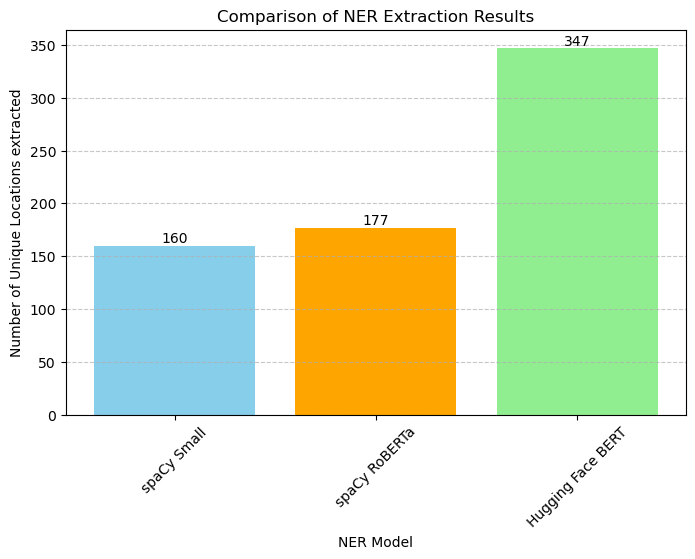

In [17]:
model_names = ['spaCy Small', 'spaCy RoBERTa', 'Hugging Face BERT']
ner_counts = [len(unique_locations_sm), len(unique_locations_trf), len(unique_locations_hf)]

plt.figure(figsize=(8,5))
bars = plt.bar(model_names, ner_counts, color=['skyblue', 'orange', 'lightgreen'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.title('Comparison of NER Extraction Results')
plt.xlabel('NER Model')
plt.ylabel('Number of Unique Locations extracted')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 3.6 Comparative Analysis of Validated GPE Counts Across Models

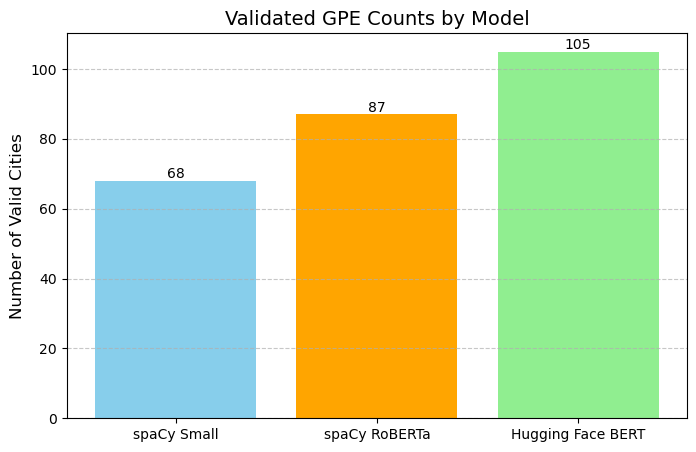

In [18]:
model_names = ['spaCy Small', 'spaCy RoBERTa', 'Hugging Face BERT']
valid_counts = [len(valid_locations_sm), len(valid_locations_trf), len(valid_locations_hf)]

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, valid_counts, color=['skyblue', 'orange', 'lightgreen'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}', ha='center', va='bottom', fontsize=10)

# Titles and labels
plt.title('Validated GPE Counts by Model', fontsize=14)
plt.ylabel('Number of Valid Cities', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

#### 3.7 Differences in Validated GPEs Across Models

In [19]:
# Calculate differences between the models
diff_sm = valid_locations_sm - valid_locations_trf - valid_locations_hf

print(f"\nLocations found by gpe_trf but not by gpe_sm ({len(diff_sm)} locations):")
print(sorted(diff_sm))


Locations found by gpe_trf but not by gpe_sm (3 locations):
['Fort Wayne', 'Hum', 'Pittsburgh']


In [20]:
diff_trf = valid_locations_trf - valid_locations_sm - valid_locations_hf

print(f"\nLocations found by gpe_hf but not by gpe_trf ({len(diff_trf)} locations):")
print(sorted(diff_trf))


Locations found by gpe_hf but not by gpe_trf (2 locations):
['Burdwan', 'Cheshire']


In [21]:
diff_hf = valid_locations_hf - valid_locations_sm - valid_locations_trf

print(f"\nLocations found by gpe_sm but not by gpe_hf ({len(diff_hf)} locations):")
print(sorted(diff_hf))


Locations found by gpe_sm but not by gpe_hf (20 locations):
['Africa', 'And', 'Asia', 'Chu', 'Empire', 'Gibraltar', 'Golden Gate', 'Hudson', 'Inn', 'Laramie', 'Lyons', 'Mandi', 'Muddy Creek', 'No', 'Rangoon', 'Salt Lake', 'The Bridge', 'Vin', 'Weber', 'West End']


In [22]:
diff_summary = {
    "Model": ["spaCy Small", "spaCy RoBERTa", "Hugging Face BERT"],
    "Unique to Model": [
        sorted(diff_sm),   # From spaCy small only
        sorted(diff_trf),  # From spaCy RoBERTa only
        sorted(diff_hf)    # From Hugging Face only
    ],
    "Count": [
        len(diff_sm),
        len(diff_trf),
        len(diff_hf)
    ]
}

df_diff_summary = pd.DataFrame(diff_summary)
display(df_diff_summary.style.set_properties(subset=['Unique to Model'], **{'width': '500px'}))

,Model,Unique to Model,Count
0,spaCy Small,"['Fort Wayne', 'Hum', 'Pittsburgh']",3
1,spaCy RoBERTa,"['Burdwan', 'Cheshire']",2
2,Hugging Face BERT,"['Africa', 'And', 'Asia', 'Chu', 'Empire', 'Gibraltar', 'Golden Gate', 'Hudson', 'Inn', 'Laramie', 'Lyons', 'Mandi', 'Muddy Creek', 'No', 'Rangoon', 'Salt Lake', 'The Bridge', 'Vin', 'Weber', 'West End']",20


#### 3.8 Final Consolidated List of Validated GPE Locations (only the spaCy models)

In [23]:
# Combine all validated locations into one final set
final_locations = valid_locations_sm.union(valid_locations_trf)

# Convert to sorted list
final_locations_list = sorted(final_locations)

print(f"Total unique valid locations across all models: {len(final_locations_list)}")
print(f"Final valid locations: {final_locations_list}")

Total unique valid locations across all models: 93
Final valid locations: ['Aden', 'Agra', 'Allahabad', 'Athens', 'Auburn', 'Behar', 'Benares', 'Birmingham', 'Bombay', 'Bordeaux', 'Brindisi', 'Burdwan', 'Buxar', 'Calais', 'Calcutta', 'Cardiff', 'Carthage', 'Chandernagor', 'Cheshire', 'Chicago', 'Colorado', 'Columbus', 'Council Bluffs', 'Davenport', 'Denver', 'Des Moines', 'Dover', 'Dublin', 'Edinburgh', 'Egypt', 'Elko', 'Formosa', 'Fort Wayne', 'Fremont', 'Ghazipur', 'Glasgow', 'Goa', 'Gour', 'Hamburg', 'Havre', 'Holland', 'Hong Kong', 'Hum', 'Independence', 'Indiana', 'Iowa City', 'Jersey City', 'Jordan', 'Kearney', 'Kent', 'Kirkland', 'Liverpool', 'London', 'Long Island', 'Macao', 'Madras', 'Malacca', 'Manchester', 'Mexico', 'Missouri', 'Mocha', 'Nagasaki', 'New York', 'North Platte', 'Oakland', 'Ogden', 'Omaha', 'Oregon', 'Paris', 'Patna', 'Pittsburgh', 'Port Said', 'Queenstown', 'Reading', 'Reno', 'Rock Island', 'Sacramento', 'Saint Joseph', 'Salt Lake City', 'San Francisco', 'Shan

#### 3.9 Merging Validated GPEs with Original Sentences

In [24]:
# - df_ner_results_filtered : DataFrame with columns ['chapter','sent_num','gpe_sm','gpe_trf','gpe_hf']
# - df_sentences            : DataFrame with columns ['chapter','sent_num','sentence']
# - final_locations_list    : validated union of cities (sorted list)

df_final_ner = df_ner_results_filtered.copy()

# per-sentence union of all model hits
df_final_ner['final_ner_cities'] = df_final_ner.apply(
    lambda r: sorted(
        set(r.get('gpe_sm', [])) |
        set(r.get('gpe_trf', [])) |
        set(r.get('gpe_hf', []))
    ),
    axis=1
)

# keep only validated locations (case-insensitive)
final_set_lower = {loc.lower() for loc in final_locations_list}
df_final_ner['final_ner_cities'] = df_final_ner['final_ner_cities'].apply(
    lambda locs: [l for l in locs if l.lower() in final_set_lower]
)

# merge these locations back onto the original sentence table
df_final_ner = df_sentences.merge(
    df_final_ner[['chapter', 'sent_num', 'final_ner_cities']],
    on=['chapter', 'sent_num'],
    how='left'
)

# normalize None -> [] for convenience
df_final_ner['final_ner_cities'] = df_final_ner['final_ner_cities'].apply(
    lambda x: x if isinstance(x, list) else []
)

# keep only sentences that contain at least one validated location
df_final_ner = df_final_ner[df_final_ner['final_ner_cities'].map(len) > 0].copy()

# Display final results
print(f"Sentences with validated locations: {len(df_final_ner)}")
display(df_final_ner.head(10))

Sentences with validated locations: 386


,chapter,sent_num,sentence,final_ner_cities
4,1,5,"Certainly an Englishman, it was more doubtful ...",[London]
5,1,6,"He was never seen on ’Change, nor at the Bank,...","[London, Temple]"
24,1,25,It was at least certain that Phileas Fogg had ...,[London]
50,1,51,"Then I got to be a professor of gymnastics, so...",[Paris]
63,2,1,"“Faith,” muttered Passepartout, somewhat flurr...",[London]
74,2,12,"As for Passepartout, he was a true Parisian of...",[Paris]
107,3,3,"His breakfast consisted of a side-dish, a broi...","[Cheshire, Reading]"
130,3,26,"As soon as the robbery was discovered, picked ...","[Brindisi, Glasgow, Havre, Liverpool, New York..."
132,3,28,Detectives were also charged with narrowly wat...,[London]
154,3,50,"“Only eighty days, now that the section betwee...",[Allahabad]


##### 3.9.1 Exploding Sentences to Sentence–City Pairs

In [25]:
# explode to one (sentence, city) per row
df_loc_sent = df_final_ner.explode('final_ner_cities', ignore_index=True)
df_loc_sent = df_loc_sent.rename(columns={'final_ner_cities': 'cities'})

print("\nExploded (one city per row):", len(df_loc_sent))
display(df_loc_sent.head(10))


Exploded (one city per row): 571


,chapter,sent_num,sentence,cities
0,1,5,"Certainly an Englishman, it was more doubtful ...",London
1,1,6,"He was never seen on ’Change, nor at the Bank,...",London
2,1,6,"He was never seen on ’Change, nor at the Bank,...",Temple
3,1,25,It was at least certain that Phileas Fogg had ...,London
4,1,51,"Then I got to be a professor of gymnastics, so...",Paris
5,2,1,"“Faith,” muttered Passepartout, somewhat flurr...",London
6,2,12,"As for Passepartout, he was a true Parisian of...",Paris
7,3,3,"His breakfast consisted of a side-dish, a broi...",Cheshire
8,3,3,"His breakfast consisted of a side-dish, a broi...",Reading
9,3,26,"As soon as the robbery was discovered, picked ...",Brindisi


##### 3.9.2 Top 10 Cities mentioned in the Novel (Identified via NER and Validated with World Cities Database)

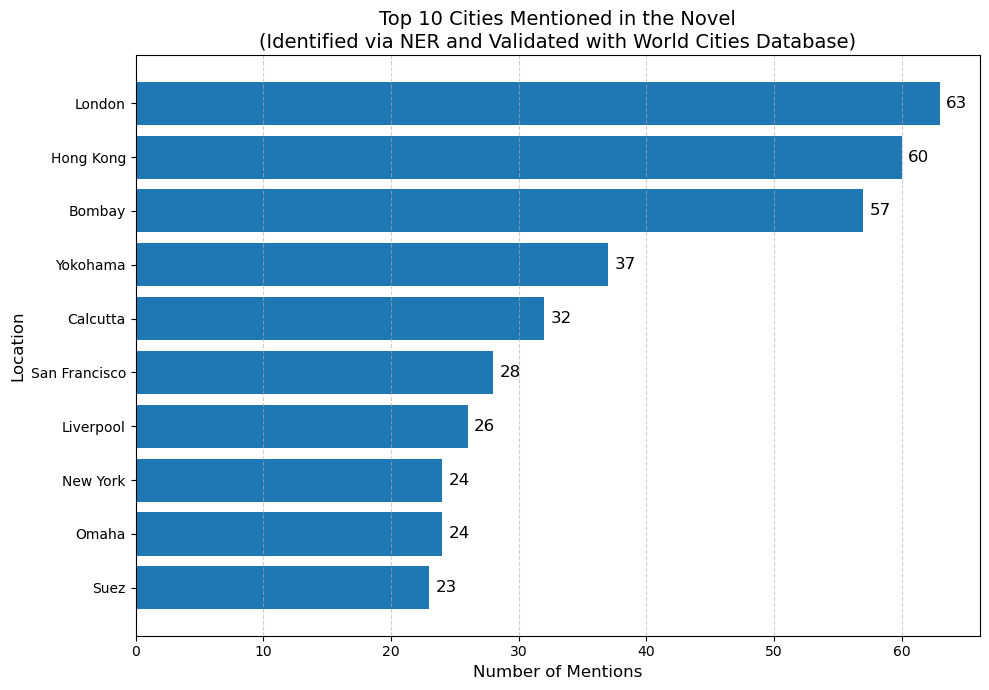

In [26]:
top10 = (
    df_loc_sent['cities']
    .value_counts()
    .head(10)
    .sort_values(ascending=True)  # plot from smallest to largest for nicer labels
)

plt.figure(figsize=(10, 7))
bars = plt.barh(top10.index, top10.values)  # horizontal bar chart

# Add value labels at the end of each bar
for bar in bars:
    w = bar.get_width()
    plt.text(w + 0.5, bar.get_y() + bar.get_height()/2, f"{int(w)}", va='center', fontsize=12)

# Titles and labels (clear and publication-friendly)
plt.title("Top 10 Cities Mentioned in the Novel\n(Identified via NER and Validated with World Cities Database)", fontsize=14)
plt.xlabel("Number of Mentions", fontsize=12)
plt.ylabel("Location", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()